In [1]:
import pandas as pd
from datetime import date, timedelta
import datetime
import numpy as np
from mixed_naive_bayes import MixedNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance

In [2]:
# load data
df = pd.read_csv('data/agg_df.csv')
df.head(5)

,order_id,customer_id,order_date,partner_id,ord_prct_source_code,ord_status_code,ord_channel_code,ord_channel_type_code,pymt_order,refund_order,couponUsed,first_purchase,number_of_purchases,isWeekday,prct_group_name,ord_prct_quantity,prct_type_code_processed
0,73542482,75151090,2019-11-12,75065.0,order,DELIVERED,PROVIDER,OFFLINE,0.0,0.0,1,True,1,1,['Bolsa lavanderia'],1,['LAUNDRY']
1,73542488,74700288,2019-08-27,74402.0,order,DELIVERED,IOS,ONLINE,9.0,0.0,1,False,2,1,['Media bolsa lavandería'],1,['LAUNDRY']
2,73542515,75550863,2019-07-25,74612.0,order,WAITING_DELIVERY,ANDROID,ONLINE,0.0,0.0,1,True,1,1,['Media bolsa lavandería'],1,['LAUNDRY']
3,73542618,75260852,2020-01-08,74678.0,order,DELIVERED,ANDROID,ONLINE,49.5,0.0,1,False,12,1,['Media bolsa lavandería' 'Bolsa lavanderia'],2,['LAUNDRY']
4,73542619,74711088,2019-12-23,74084.0,order,DELIVERED,ANDROID,ONLINE,34.0,0.0,1,False,2,1,['Bolsa lavanderia'],1,['LAUNDRY']


The goal:
Previous analysis has identified that for a customer who completes a first transaction but does not initiate a second transaction within 60 days, there is a high probability of churn (1). We assume a customer who has not returned to make a second purchase within 60 days to be churn, and a customer who returns to be not churn (0).

In [3]:
df[df['customer_id'] == 74698133]

,order_id,customer_id,order_date,partner_id,ord_prct_source_code,ord_status_code,ord_channel_code,ord_channel_type_code,pymt_order,refund_order,couponUsed,first_purchase,number_of_purchases,isWeekday,prct_group_name,ord_prct_quantity,prct_type_code_processed
24049,73988814,74698133,2019-09-25,74457.0,order,WAITING_DELIVERY,PROVIDER,OFFLINE,75.0,0.0,0,False,2,1,['Americana'],3,['DRYCLEANING']
24235,73992133,74698133,2019-10-28,74457.0,order,DELIVERED,PROVIDER,OFFLINE,100.0,0.0,0,False,3,1,['Americana'],4,['DRYCLEANING']
24688,74000506,74698133,2019-07-16,74457.0,order,DELIVERED,PROVIDER,OFFLINE,75.0,0.0,0,True,1,1,['Americana'],3,['DRYCLEANING']
25424,74013759,74698133,2019-11-07,74457.0,order,DELIVERED,PROVIDER,OFFLINE,120.0,0.0,0,False,4,1,['Otro'],4,['LAUNDRY']


In [4]:
# how many unique customers?
len(df.customer_id.unique()), len(df)

(34034, 109005)

Clearly some of these orders are not churn. What is the last date of order modification?

Change order_date to date_time.
Make a list of order dates for each customer. 
If customer had second order within 60 days, they are not churn. 
Otherwise they are churn. 
Remove "new" customers who have not had a chance to churn or not, yet. Set those aside for the deployment. 


In [5]:
# change order_date to datetime
df['order_date'] = pd.to_datetime(df['order_date'], infer_datetime_format=True)

In [6]:
churn_df = df.groupby('customer_id')['order_date'].apply(list)


In [7]:
churn_df = pd.DataFrame(churn_df)

In [8]:
churn_df.head()

,order_date
customer_id,
74698133,"[2019-09-25 00:00:00, 2019-10-28 00:00:00, 201..."
74698153,[2020-03-18 00:00:00]
74698168,[2019-06-27 00:00:00]
74698215,[2019-07-30 00:00:00]
74698262,"[2019-09-30 00:00:00, 2020-09-02 00:00:00]"


In [9]:
# create threshold of "indetermination" of churn
naThreshold_end = (datetime.datetime.utcnow() - (df.order_date.max() - timedelta(59))).days
naThreshold_start = (datetime.datetime.utcnow() - (df.order_date.min() + timedelta(59))).days
print(naThreshold_end, naThreshold_start)

120 1006


In [10]:
def is_churn(list):
    # function days a list of timestamps for a user
    # and returns 1 if the user is an adopter, else returns 0
    
    days = []
    
    # Change the list of times to a list of ints
    for item in list:
        delta = (datetime.datetime.utcnow() - item).days
        days.append(delta)
    
    # sort list, in case orders aren't chronologically logged
    days.sort()
    
    c = int(1)
    if len(days) == 1:
        if days[0] <= naThreshold_end:
            c=int(3)
            return int(c)
        if days[0] >= naThreshold_start:
            c=int(3)
            return int(c)
        else:
            c=int(1)
            return int(c)
    if len(days) > 2:
        c=int(0)
        return int(c)
    
    
    for i in range(len(days)-1):
    
        if days[i] - days[i+1] >= 60:
            c = int(1)
            return int(c)
        else:
            c=int(1)
            return int(c)


In [11]:
list = churn_df.loc[74698133, 'order_date']
print(list)

[Timestamp('2019-09-25 00:00:00'), Timestamp('2019-10-28 00:00:00'), Timestamp('2019-07-16 00:00:00'), Timestamp('2019-11-07 00:00:00')]


In [12]:
type(is_churn(list))

int

In [13]:
for id, list in zip(churn_df.index, churn_df.order_date):
    x = is_churn(list)
    churn_df.loc[id, 'is_Churn'] = int(x)

In [14]:
churn_df.groupby(['is_Churn']).count()

,order_date
is_Churn,
0.0,9476
1.0,23414
3.0,1144


In [15]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34034 entries, 74698133 to 1155819823
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   order_date  34034 non-null  object 
 1   is_Churn    34034 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.8+ MB


In [16]:
# merge Churn to df
merged = pd.merge(df, churn_df, on='customer_id', validate ="many_to_one")

In [17]:
merged.head()

,order_id,customer_id,order_date_x,partner_id,ord_prct_source_code,ord_status_code,ord_channel_code,ord_channel_type_code,pymt_order,refund_order,couponUsed,first_purchase,number_of_purchases,isWeekday,prct_group_name,ord_prct_quantity,prct_type_code_processed,order_date_y,is_Churn
0,73542482,75151090,2019-11-12,75065.0,order,DELIVERED,PROVIDER,OFFLINE,0.00,0.0,1,True,1,1,['Bolsa lavanderia'],1,['LAUNDRY'],"[2019-11-12 00:00:00, 2019-12-13 00:00:00, 201...",0.0
1,73549868,75151090,2019-12-13,75065.0,order,DELIVERED,IOS,ONLINE,41.48,0.0,1,False,5,1,['Bolsa lavanderia'],1,['LAUNDRY'],"[2019-11-12 00:00:00, 2019-12-13 00:00:00, 201...",0.0
2,73565177,75151090,2019-12-03,75065.0,order,DELIVERED,PROVIDER,OFFLINE,68.00,0.0,0,False,4,1,['Bolsa lavanderia'],1,['LAUNDRY'],"[2019-11-12 00:00:00, 2019-12-13 00:00:00, 201...",0.0
3,73617829,75151090,2019-11-12,75065.0,order,DELIVERED,PROVIDER,OFFLINE,8.00,0.0,0,False,2,1,['Partner'],1,['HOME'],"[2019-11-12 00:00:00, 2019-12-13 00:00:00, 201...",0.0
4,73626880,75151090,2019-11-14,75065.0,order,DELIVERED,PROVIDER,OFFLINE,40.00,0.0,0,False,3,1,['Traje 2 piezas'],1,['DRYCLEANING'],"[2019-11-12 00:00:00, 2019-12-13 00:00:00, 201...",0.0


In [18]:
merged.drop(columns=['order_date_y'], axis=1, inplace=True)

In [19]:
merged.rename(columns={'order_date_x':'order_date'}, inplace=True)

In [20]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109005 entries, 0 to 109004
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   order_id                  109005 non-null  int64         
 1   customer_id               109005 non-null  int64         
 2   order_date                109005 non-null  datetime64[ns]
 3   partner_id                109005 non-null  float64       
 4   ord_prct_source_code      109005 non-null  object        
 5   ord_status_code           109005 non-null  object        
 6   ord_channel_code          109005 non-null  object        
 7   ord_channel_type_code     109005 non-null  object        
 8   pymt_order                109005 non-null  float64       
 9   refund_order              109005 non-null  float64       
 10  couponUsed                109005 non-null  int64         
 11  first_purchase            109005 non-null  bool          
 12  nu

## Create New Features

In [21]:
# Populate a column, 'Coupon_On_First_Order', with 1 if it is first order and coupon is used.
conditions = [merged['first_purchase'].eq(True) & merged['couponUsed'].eq(1)]
choices = [1]
merged['Coupon_Used_First_Purchase'] = np.select(conditions, choices, default=0)
# converting type of columns to 'category'
merged['Coupon_Used_First_Purchase'] = merged['Coupon_Used_First_Purchase'].astype('category')

In [22]:
# Drop 'couponUsed' column
merged.drop(columns=['couponUsed'], axis=1, inplace=True)

In [23]:
# Change the refund column to refund, or not refund
# converting type of columns to 'category'

merged['isRefund'] = [1 if x != 0 else 0 for x in merged['refund_order']]
# converting type of columns to 'category'
merged['isRefund'] = merged['isRefund'].astype('category')
# Assigning numerical values and storing in another column
merged['Refund_Cat'] = merged['isRefund'].cat.codes


In [24]:
# drop 'refund_order' columns
merged.drop(columns=['refund_order'], axis=1, inplace=True)

In [26]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109005 entries, 0 to 109004
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   order_id                    109005 non-null  int64         
 1   customer_id                 109005 non-null  int64         
 2   order_date                  109005 non-null  datetime64[ns]
 3   partner_id                  109005 non-null  float64       
 4   ord_prct_source_code        109005 non-null  object        
 5   ord_status_code             109005 non-null  object        
 6   ord_channel_code            109005 non-null  object        
 7   ord_channel_type_code       109005 non-null  object        
 8   pymt_order                  109005 non-null  float64       
 9   first_purchase              109005 non-null  bool          
 10  number_of_purchases         109005 non-null  int64         
 11  isWeekday                   109005 non-

## Change Features to Categoricals

In [27]:
# ord_prct_source_code - Order vs Provider
merged['Source_Is_Provider'] = [1 if x != 'order' else 0 for x in merged['ord_prct_source_code']]
merged['Source_Is_Provider'] = merged['Source_Is_Provider'].astype('category')
# Assigning numerical values and storing in another column
merged['Source_Cat'] = merged['Source_Is_Provider'].cat.codes

In [28]:
# ord_channel_type_code - Online vs Offline
merged['Is_Online'] = [1 if x == 'ONLINE' else 0 for x in merged['ord_channel_type_code']]
merged['Is_Online'] = merged['Is_Online'].astype('category')
# Assigning numerical values and storing in another column
merged['Online_Cat'] = merged['Is_Online'].cat.codes

In [30]:
# is first purchase
merged['Is_First_Purchase'] = [1 if x == True else 0 for x in merged['first_purchase']]
merged['Is_First_Purchase'] = merged['Is_First_Purchase'].astype('category')
# Assigning numerical values and storing in another column
merged['FirstPurchaseCat'] = merged['Is_First_Purchase'].cat.codes

In [43]:
merged['is_Churn'] = merged['is_Churn'].astype('category')
# Assigning numerical values and storing in another column
merged['is_ChurnCat'] = merged['is_Churn'].cat.codes

prct_type_code_processed and ord_status_code might be one-hot encoded

In [44]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109005 entries, 0 to 109004
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   order_id                    109005 non-null  int64         
 1   customer_id                 109005 non-null  int64         
 2   order_date                  109005 non-null  datetime64[ns]
 3   partner_id                  109005 non-null  float64       
 4   ord_prct_source_code        109005 non-null  object        
 5   ord_status_code             109005 non-null  object        
 6   ord_channel_code            109005 non-null  object        
 7   ord_channel_type_code       109005 non-null  object        
 8   pymt_order                  109005 non-null  float64       
 9   first_purchase              109005 non-null  bool          
 10  number_of_purchases         109005 non-null  int64         
 11  isWeekday                   109005 non-

## Separate out columns for machine learning

In [48]:
ml.is_ChurnCat.unique()

array([0, 1, 2], dtype=int8)

In [60]:
 ml = merged[['isWeekday', 'pymt_order',  'ord_prct_quantity', 'Coupon_Used_First_Purchase', 'isRefund', 
              'Source_Is_Provider', 'Is_Online', 'Is_First_Purchase', 'is_Churn']]

Set aside the rows where is_churn is equal to NA. Those rows are indeterminate due to the dates of the orders within.

In [61]:
indeterminate = ml.loc[ml['is_Churn'] == 3]
ml = ml[ml['is_Churn'].isin([0,1])]

In [62]:
ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107861 entries, 0 to 108987
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   isWeekday                   107861 non-null  int64   
 1   pymt_order                  107861 non-null  float64 
 2   ord_prct_quantity           107861 non-null  int64   
 3   Coupon_Used_First_Purchase  107861 non-null  category
 4   isRefund                    107861 non-null  category
 5   Source_Is_Provider          107861 non-null  category
 6   Is_Online                   107861 non-null  category
 7   Is_First_Purchase           107861 non-null  category
 8   is_Churn                    107861 non-null  category
dtypes: category(6), float64(1), int64(2)
memory usage: 3.9 MB


In [63]:
col = ['isWeekday', 'Coupon_Used_First_Purchase', 'isRefund', 'Source_Is_Provider',
            'Is_Online', 'Is_First_Purchase']
# Switch most to categoricals
for column in col:
    ml[column] = ml[column].astype('category')

ml.ord_prct_quantity = ml.ord_prct_quantity.astype('float')


In [64]:
ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107861 entries, 0 to 108987
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   isWeekday                   107861 non-null  category
 1   pymt_order                  107861 non-null  float64 
 2   ord_prct_quantity           107861 non-null  float64 
 3   Coupon_Used_First_Purchase  107861 non-null  category
 4   isRefund                    107861 non-null  category
 5   Source_Is_Provider          107861 non-null  category
 6   Is_Online                   107861 non-null  category
 7   Is_First_Purchase           107861 non-null  category
 8   is_Churn                    107861 non-null  category
dtypes: category(7), float64(2)
memory usage: 3.2 MB


In [67]:
# Split X and y

X = ml.drop(columns=['is_Churn'])
y = ml.is_Churn

In [68]:
# Check the location of the categorical columns for assigment to the Multinoulli naive Bayes algorithm. 
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107861 entries, 0 to 108987
Data columns (total 8 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   isWeekday                   107861 non-null  category
 1   pymt_order                  107861 non-null  float64 
 2   ord_prct_quantity           107861 non-null  float64 
 3   Coupon_Used_First_Purchase  107861 non-null  category
 4   isRefund                    107861 non-null  category
 5   Source_Is_Provider          107861 non-null  category
 6   Is_Online                   107861 non-null  category
 7   Is_First_Purchase           107861 non-null  category
dtypes: category(6), float64(2)
memory usage: 3.1 MB


In [69]:
# implement train/test split from sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [70]:
# check shape of X
X_train.shape, X_test.shape

((75502, 8), (32359, 8))

In [71]:
# check shape of y
y_train.shape, y_test.shape

((75502,), (32359,))

In [75]:
# instantiate model, fit and predict
from sklearn.tree import DecisionTreeClassifier
DTC = DecisionTreeClassifier()
DTC.fit(X_train,y_train)
DTC.predict(X_test)

array([0., 0., 0., ..., 1., 1., 0.])

In [76]:
#Predict the test set results

y_pred = DTC.predict(X_test)

#Create the confusion matrix

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

cm 

array([[21289,  2360],
       [ 2717,  5993]], dtype=int64)

In [77]:
DTC.score(X_test, y_test)

0.8431039278098829

In [79]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier()
RFC.fit(X_train, y_train)
RFC.predict(X_test)

array([0., 1., 0., ..., 1., 1., 0.])

In [81]:
#Predict the test set results

y_pred = RFC.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[21212,  2437],
       [ 2550,  6160]], dtype=int64)

In [82]:
RFC.score(X_test, y_test)

0.8458852251305664

## Try Different Features?

In [93]:
 ml = merged[['isWeekday', 'Coupon_Used_First_Purchase', 'isRefund', 
              'Source_Is_Provider', 'Is_Online', 'is_Churn']]

In [94]:
indeterminate = ml.loc[ml['is_Churn'] == 3]
ml = ml[ml['is_Churn'].isin([0,1])]

In [95]:
# Split X and y

X = ml.drop(columns=['is_Churn'])
y = ml.is_Churn

In [96]:
# implement train/test split from sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [97]:
RFC = RandomForestClassifier()
RFC.fit(X_train, y_train)
RFC.predict(X_test)

array([0., 0., 0., ..., 0., 0., 0.])

In [98]:
#Predict the test set results

y_pred = RFC.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[23348,   301],
       [ 7973,   737]], dtype=int64)

In [99]:
RFC.score(X_test, y_test)

0.7443060663184895

In [100]:
importances = RFC.feature_importances_
#
# Sort the feature importance in descending order
#
sorted_indices = np.argsort(importances)[::-1]

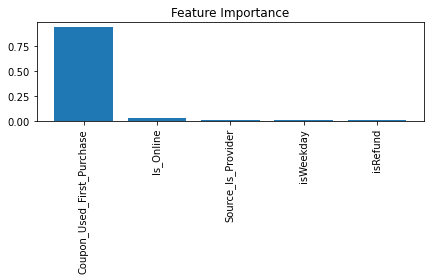

In [101]:
import matplotlib.pyplot as plt
 
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()